## Setup

In [2]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

## Load in Saved XGBoost Model & Data

In [3]:
# Load in trained model
bst = pickle.load(open("../3. ML/bst.pickle.dat", "rb"))

In [4]:
df = pd.read_csv('../data/formatted_mens.csv',header=0,parse_dates=["Date"])
df.dropna(inplace=True)

categorical_cols = ['Tournament', 'Court', 'Surface', 'Round', 'A', 'B']
df = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

In [5]:
df[['Date','y']+bst.feature_names].sort_values(by='Date',inplace=True) #Match model feature labels

## Check we have no missing or extra features
print([c for c in df.columns if c not in bst.feature_names]) # Should be date & y
print([c for c in bst.feature_names if c not in df.columns]) # Should be empty

['Date', 'y']
[]


In [6]:
split_time = pd.to_datetime('2018-01-01') # SAME SPLIT FROM ML EXPLORING
df = df.loc[df['Date']>=split_time]

## Make Predictions

In [7]:
d = xgb.DMatrix(df.drop(columns=['Date','y']), label=df['y'])
df['prediction'] = bst.predict(d)

In [8]:
df['betting_direction'] = (df['prediction'] > 0.5).astype('uint8')
df['correct'] = df['betting_direction'] == df['y']
df

,Date,A_rank,B_rank,APts,BPts,A_Max,B_Max,A_Avg,B_Avg,A_hist_form,...,B_Zhang Ze,B_Zhang Ze.,B_Zhang Zh.,B_Ziadi M.,B_Zopp J.,B_Zverev A.,B_Zverev M.,prediction,betting_direction,correct
44664,2018-01-01,47.0,52.0,1010.0,909.0,1.75,2.35,1.67,2.17,0.50,...,0,0,0,0,0,0,0,0.493191,0,False
44665,2018-01-01,76.0,79.0,670.0,662.0,2.52,1.65,2.37,1.58,0.50,...,0,0,0,0,0,0,0,0.393546,0,False
44666,2018-01-01,218.0,33.0,235.0,1302.0,3.00,1.57,2.73,1.44,0.50,...,0,0,0,0,0,0,1,0.403896,0,True
44667,2018-01-01,66.0,120.0,768.0,498.0,2.38,1.75,2.20,1.66,0.50,...,0,0,0,0,0,0,0,0.416970,0,False
44668,2018-01-01,54.0,94.0,890.0,593.0,2.00,2.02,1.89,1.89,0.50,...,0,0,0,0,0,0,0,0.508752,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,2020-11-20,7.0,1.0,5525.0,11830.0,3.92,1.35,3.52,1.31,0.40,...,0,0,0,0,0,0,0,0.247224,0,True
50583,2020-11-20,9.0,4.0,3455.0,6970.0,4.00,1.40,3.60,1.29,0.00,...,0,0,0,0,0,0,0,0.196349,0,True
50584,2020-11-21,3.0,1.0,9125.0,11830.0,2.70,1.66,2.47,1.56,0.30,...,0,0,0,0,0,0,0,0.384299,0,False
50585,2020-11-21,4.0,2.0,6970.0,9850.0,1.95,2.20,1.80,2.04,0.00,...,0,0,0,0,0,0,0,0.569718,1,True


In [9]:
predictions_df = df.loc[:,['prediction','correct']]
df['correct'].mean()

0.6769672407970281

Text(0, 0.5, 'Accuracy')

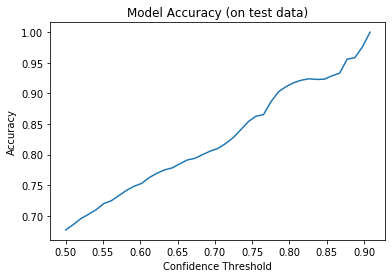

In [10]:
confident_accuracies = []
for p_threshold in np.linspace(0.5,1):
    accuracy = predictions_df[(predictions_df.prediction>p_threshold) | (predictions_df.prediction<1-p_threshold)]['correct'].mean()
    confident_accuracies.append(accuracy)

plt.plot(np.linspace(0.5,1),confident_accuracies)
plt.title('Model Accuracy (on test data)')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Number of readings')

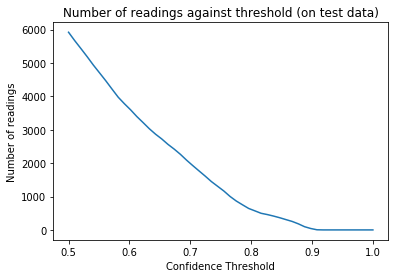

In [16]:
confident_readings = []
for p_threshold in np.linspace(0.5,1):
    readings = len(predictions_df[(predictions_df.prediction>p_threshold) | (predictions_df.prediction<1-p_threshold)]['correct'].index)
    #len(DataFrame.index)
    confident_readings.append(readings)

plt.plot(np.linspace(0.5,1),confident_readings)
plt.title('Number of readings against threshold (on test data)')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of readings')

In [17]:
use_best_odds = True

if use_best_odds:
    df[['A_odds','B_odds']] = df[['A_Max','B_Max']]
else:
    df[['A_odds','B_odds']] = df[['A_Avg','B_Avg']]

df.head()

,Date,A_rank,B_rank,APts,BPts,A_Max,B_Max,A_Avg,B_Avg,A_hist_form,...,B_Zhang Zh.,B_Ziadi M.,B_Zopp J.,B_Zverev A.,B_Zverev M.,prediction,betting_direction,correct,A_odds,B_odds
44664,2018-01-01,47.0,52.0,1010.0,909.0,1.75,2.35,1.67,2.17,0.5,...,0,0,0,0,0,0.493191,0,False,1.75,2.35
44665,2018-01-01,76.0,79.0,670.0,662.0,2.52,1.65,2.37,1.58,0.5,...,0,0,0,0,0,0.393546,0,False,2.52,1.65
44666,2018-01-01,218.0,33.0,235.0,1302.0,3.00,1.57,2.73,1.44,0.5,...,0,0,0,0,1,0.403896,0,True,3.00,1.57
44667,2018-01-01,66.0,120.0,768.0,498.0,2.38,1.75,2.20,1.66,0.5,...,0,0,0,0,0,0.416970,0,False,2.38,1.75
44668,2018-01-01,54.0,94.0,890.0,593.0,2.00,2.02,1.89,1.89,0.5,...,0,0,0,0,0,0.508752,1,True,2.00,2.02


## Betting Strategy

In [33]:
df =df[["Date","y","prediction","A_odds","B_odds"]]
# y =1 if player 1 wins, y=0 if player 2 wins
df["Bookies Cut"] = df.apply(lambda row: 1-(1/(row["A_odds"])+1/(row["B_odds"])),axis=1)
df["Bookies Interval"] = df.apply(lambda row: (1/(row["B_odds"]),1/(row["A_odds"])),axis=1)
df.head()

,Date,y,prediction,A_odds,B_odds,Bookies Cut,Bookies Interval
44664,2018-01-01,1,0.493191,1.75,2.35,0.003040,"(0.425531914893617, 0.5714285714285714)"
44665,2018-01-01,1,0.393546,2.52,1.65,-0.002886,"(0.6060606060606061, 0.3968253968253968)"
44666,2018-01-01,0,0.403896,3.00,1.57,0.029724,"(0.6369426751592356, 0.3333333333333333)"
44667,2018-01-01,1,0.416970,2.38,1.75,0.008403,"(0.5714285714285714, 0.42016806722689076)"
44668,2018-01-01,1,0.508752,2.00,2.02,0.004950,"(0.49504950495049505, 0.5)"


In [86]:
k=1.2
df["bet on A"]= (df["prediction"] > 1/df["A_odds"] * k)
df["bet on B"] = ((1-df["prediction"]) > 1/df["B_odds"] * k) 
print(df["bet on A"].sum()/len(df.index), df["bet on A"].sum())
print(df["bet on B"].sum()/len(df.index),df["bet on B"].sum())
print(len(df[(df["bet on A"] == True) & (df["bet on B"] == True)].index))

0.129854778790949 769
0.12681526511313745 751
0


## Now we backtest
First we will bet the same amount on every bet

     k  WalletValue  numberOfBets
0  0.8       -16.37         11740
1  1.0        22.49          6122
2  1.2       -23.31          1520
3  1.4       -21.23           581


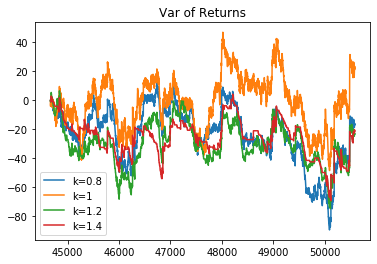

In [102]:
bettingCount = []
walletValue = []
kvalue =[]


for k in [0.8,1,1.2,1.4]:
    
    df["bet on A"]= (df["prediction"] > 1/df["A_odds"] * k)
    df["bet on B"] = ((1-df["prediction"]) > 1/df["B_odds"] * k) 
    
    BacktestWallet = []
    # print(df["bet on A"].sum()/len(df.index), df["bet on A"].sum())
    count = 0
    wallet = 0 
    for index, row in df.iterrows():
        if (row["bet on A"] == True and row["y"] == 1):
            count = count + 1
            wallet += row["A_odds"]-1
        if (row["bet on A"] == True and row["y"] == 0):
            count = count + 1
            wallet = wallet - 1
        if (row["bet on B"] == True and row["y"] == 0):
            count = count + 1
            wallet += row["B_odds"]-1
        if (row["bet on B"] == True and row["y"] == 1):
            count = count + 1
            wallet = wallet - 1 
        BacktestWallet.append(wallet)
        
        
    bettingCount.append(count)
    walletValue.append(wallet)
    kvalue.append(k)
    df["wallet"] = BacktestWallet
    plt.plot(df['wallet'], label="k="+str(k))

plt.legend()
plt.title('Var of Returns')
d = {'k': kvalue, 'WalletValue': walletValue, 'numberOfBets': bettingCount}
strategies = pd.DataFrame(data=d)
print(strategies)